# Exploring Dataset and Feature Engineering

## Saving Zone Information

In [255]:
dfzone = pd.read_csv("../raw_data/large/taxi+_zone_lookup.csv")

## Saving NYC Taxi Data

In [180]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
import zipfile
from pyproj import Proj, transform
import shapefile
from six import StringIO 
# a nice way of filtering out deprecated warnings
import warnings
warnings.filterwarnings("ignore")


In [181]:
df2019 = pd.read_csv("../data/large/yellow_tripdata_2019-03.csv")
df20192 = pd.read_csv("../data/large/yellow_tripdata_2019-04.csv")
df20193 = pd.read_csv("../data/large/yellow_tripdata_2019-05.csv")

In [182]:
df2019.reset_index().to_feather('../data/lab_specific/df2019.feather')
df20192.reset_index().to_feather('../data/lab_specific/df20192.feather')
df20193.reset_index().to_feather('../data/lab_specific/df20193.feather')

In [183]:
df2019 = pd.read_feather('../data/lab_specific/df2019.feather')
df20192 = pd.read_feather('../data/lab_specific/df20192.feather')
df20193 = pd.read_feather('../data/lab_specific/df20193.feather')

The following code joins the data for each year

In [184]:
df_taxi = df2019.append(df20192, ignore_index = True)
df_taxi = df_taxi.append(df20193, ignore_index = True)

In [185]:
# reduce memory usage
del df2019
del df20192
del df20193

In [186]:
df_taxi.head()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,0,1,2019-03-01 00:24:41,2019-03-01 00:25:31,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0.00,0.3,3.80,0.0
1,1,1,2019-03-01 00:25:27,2019-03-01 00:36:37,2,3.7,1,N,95,130,1,13.0,0.5,0.5,0.7,0.00,0.3,15.00,0.0
2,2,1,2019-03-01 00:05:21,2019-03-01 00:38:23,1,14.1,1,N,249,28,1,41.0,3.0,0.5,10.1,5.76,0.3,60.66,2.5
3,3,1,2019-03-01 00:48:55,2019-03-01 01:06:03,1,9.6,1,N,138,98,2,27.0,0.5,0.5,0.0,0.00,0.3,28.30,0.0
4,4,1,2019-03-01 00:11:42,2019-03-01 00:16:40,1,0.8,1,N,48,48,1,5.5,3.0,0.5,3.0,0.00,0.3,12.30,2.5


In [187]:
old_size= len(df_taxi)
old_size

22830945

### Convert datatypes to appropriate datatypes

In [188]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22830945 entries, 0 to 22830944
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   index                  int64  
 1   VendorID               int64  
 2   tpep_pickup_datetime   object 
 3   tpep_dropoff_datetime  object 
 4   passenger_count        int64  
 5   trip_distance          float64
 6   RatecodeID             int64  
 7   store_and_fwd_flag     object 
 8   PULocationID           int64  
 9   DOLocationID           int64  
 10  payment_type           int64  
 11  fare_amount            float64
 12  extra                  float64
 13  mta_tax                float64
 14  tip_amount             float64
 15  tolls_amount           float64
 16  improvement_surcharge  float64
 17  total_amount           float64
 18  congestion_surcharge   float64
dtypes: float64(9), int64(7), object(3)
memory usage: 3.2+ GB


First, reduce memory usage by changing to appropriate data type

In [189]:

#convert to int8
for i in ['VendorID', 'RatecodeID', 'passenger_count','payment_type','PULocationID', 
          'DOLocationID']:
    df_taxi[i]= df_taxi[i].astype('int16')

#convert to float32
for i in [ 'trip_distance','fare_amount', 
          'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
          'improvement_surcharge', 'total_amount',
          'congestion_surcharge']:
    df_taxi[i]= df_taxi[i].astype('float32')
    


As seen in the .info(), the datetime columns have a data type of an object, convert it to a datatime date type in order to access more features.

In [ ]:
df_taxi['tpep_pickup_datetime']= df_taxi['tpep_pickup_datetime'].apply(lambda ogdate: datetime.strptime(str(ogdate), '%Y-%m-%d %H:%M:%S'))
print("converted pickup to ", type(df_taxi['tpep_pickup_datetime'][0]))
df_taxi['tpep_dropoff_datetime']= df_taxi['tpep_dropoff_datetime'].apply(lambda ogdate: datetime.strptime(str(ogdate), '%Y-%m-%d %H:%M:%S'))
print("converted dropoff to ", type(df_taxi['tpep_dropoff_datetime'][0]))

### Delete the irrelevant columns

In [191]:
df_taxi= df_taxi.drop(columns=['index', 'store_and_fwd_flag'])

In [192]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22830945 entries, 0 to 22830944
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int16         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int16         
 4   trip_distance          float32       
 5   RatecodeID             int16         
 6   PULocationID           int16         
 7   DOLocationID           int16         
 8   payment_type           int16         
 9   fare_amount            float32       
 10  extra                  float32       
 11  mta_tax                float32       
 12  tip_amount             float32       
 13  tolls_amount           float32       
 14  improvement_surcharge  float32       
 15  total_amount           float32       
 16  congestion_surcharge   float32       
dtypes: datetime64[ns](2), float32(9), int16(6)
memory usage: 1.4 GB

Basic Intuitions based on columns:
    
    1. Date and Location feature will be relevant for the model that predicts taxi demand

### SUMMARY: Sorted Taxi Data Types for further cleaning

- Geographical data: PULocationID , DOLocationID
- Datatime data: tpep_pickup_datetime, tpep_dropoff_datetime
- Categorical Data: VendorID, RatecodeID, payment_type 
- Numerical Data: passenger_count, trip_distance, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surchage, total_amount, congestion_surcharge

## Save Uber Data

In [330]:
# Load CSV 
dffhv2019 = pd.read_csv("../data/large/fhv_tripdata_2019-03.csv")
dffhv20192 = pd.read_csv("../data/large/fhv_tripdata_2019-04.csv")
dffhv20193 = pd.read_csv("../data/large/fhv_tripdata_2019-05.csv")

dffhv2019.reset_index().to_feather("../data/fhv_tripdata_2019-03.feather")
dffhv20192.reset_index().to_feather("../data/fhv_tripdata_2019-04.feather")
dffhv20193.reset_index().to_feather("../data/fhv_tripdata_2019-05.feather")

dffhv2019 = pd.read_feather("../data/fhv_tripdata_2019-03.feather")
dffhv20192 = pd.read_feather("../data/fhv_tripdata_2019-04.feather")
dffhv20193 = pd.read_feather("../data/fhv_tripdata_2019-05.feather")

#The following code joins the data for each year

df_fhv = dffhv2019.append(dffhv20192, ignore_index = True)
df_fhv = df_fhv.append(dffhv20193, ignore_index = True)

In [331]:
# reduce memory usage
del dffhv2019
del dffhv20192
del dffhv20193

In [332]:
print(df_fhv.shape)
df_fhv.head()

(5277989, 7)


,index,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag
0,0,B00013,2019-03-01 00:09:15,2019-03-01 00:26:20,264,264,NaN
1,1,B00013,2019-03-01 00:00:08,2019-03-02 00:30:33,264,264,NaN
2,2,B00013,2019-03-01 00:55:38,2019-03-01 01:03:13,264,264,NaN
3,3,B00013,2019-03-01 00:56:30,2019-03-01 01:00:43,264,264,NaN
4,4,B00014,2019-03-01 00:53:03,2019-03-01 00:59:46,264,264,NaN


In [333]:
old_size_fhv= len(df_fhv)

In [334]:
df_fhv.describe().round()

,index,PULocationID,DOLocationID,SR_Flag
count,5277989.0,5277989.0,5277989.0,0.0
mean,906804.0,249.0,250.0,NaN
std,549121.0,49.0,49.0,NaN
min,0.0,1.0,1.0,NaN
25%,439832.0,264.0,264.0,NaN
50%,879664.0,264.0,265.0,NaN
75%,1319497.0,264.0,265.0,NaN
max,2040812.0,265.0,265.0,NaN


### Check for Invalid Location ID

In [335]:
df_fhv.loc[df_fhv['PULocationID']<0]

,index,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag


### Check Null Values

In [336]:
#check if there is missing entries
print(df_fhv.isnull().sum())

index                         0
dispatching_base_num          0
pickup_datetime               0
dropoff_datetime              0
PULocationID                  0
DOLocationID                  0
SR_Flag                 5277989
dtype: int64


In [337]:
print(df_fhv["SR_Flag"])

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
5277984   NaN
5277985   NaN
5277986   NaN
5277987   NaN
5277988   NaN
Name: SR_Flag, Length: 5277989, dtype: float64


### Delete the irrelevant columns

In [338]:
del df_fhv["SR_Flag"]

In [339]:
del df_fhv["index"]

Since locationID is very relevant, the entries with missing locationID values should be removed. However, there is no need to remove any rows since there is no missing locationID data

### Convert datatypes to appropriate datatypes

In [340]:
df_fhv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5277989 entries, 0 to 5277988
Data columns (total 5 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   dispatching_base_num  object
 1   pickup_datetime       object
 2   dropoff_datetime      object
 3   PULocationID          int64 
 4   DOLocationID          int64 
dtypes: int64(2), object(3)
memory usage: 201.3+ MB


First, reduce memory usage for running 

In [341]:
#convert to Location IDs to int8
for i in ["PULocationID", "DOLocationID"]:
    df_fhv[i]= df_fhv[i].astype('int16')

As seen in the .info(), the datetime columns have a data type of an object, convert it to a datatime date type in order to access more features.

In [344]:
df_fhv['pickup_datetime']= df_fhv['pickup_datetime'].apply(lambda ogdate: datetime.strptime(str(ogdate), '%Y-%m-%d %H:%M:%S'))
print("converted pickup to ", type(df_fhv['pickup_datetime'][0]))
df_fhv['dropoff_datetime']= df_fhv['dropoff_datetime'].apply(lambda ogdate: datetime.strptime(str(ogdate), '%Y-%m-%d %H:%M:%S'))
print("converted dropoff to", type(df_fhv['dropoff_datetime'][0]))

KeyboardInterrupt: 

In [347]:
print(df_fhv['pickup_datetime'][0])
print(type(df_fhv['pickup_datetime'][0]))
print(df_fhv['dropoff_datetime'][0])
print(type(df_fhv['dropoff_datetime'][0]))

2019-03-01 00:09:15
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2019-03-01 00:26:20
<class 'datetime.datetime'>


In [343]:
df_fhv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5277989 entries, 0 to 5277988
Data columns (total 5 columns):
 #   Column                Dtype         
---  ------                -----         
 0   dispatching_base_num  object        
 1   pickup_datetime       datetime64[ns]
 2   dropoff_datetime      object        
 3   PULocationID          int16         
 4   DOLocationID          int16         
dtypes: datetime64[ns](1), int16(2), object(2)
memory usage: 140.9+ MB


### SUMMARY: Sorted FHV Data Types for further cleaning
- Geographical data: PULocationID , DOLocationID
- Datatime data: pickup_datetime, dropoff_datetime

## Cleaning DateTime Data for Taxi and FHV datasets

### Remove invalid trips

Check for and remove invalid trips where there was a pickup after the dropoff. There cannot be a trip where there is 0 seconds trip since there is a minimum of 2.50 fee.

Taxi Dataset:

In [323]:
df_taxi.loc[df_taxi['tpep_pickup_datetime']>= df_taxi['tpep_dropoff_datetime']].count()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
total_trip_duration      0
avespeed_mileshr         0
date                     0
time session             0
dtype: int64

In [324]:
df_taxi= df_taxi.loc[df_taxi['tpep_pickup_datetime']< df_taxi['tpep_dropoff_datetime']]

FHV Dataset:

In [327]:
df_fhv.loc[df_taxi['pickup_datetime']>= df_fhv['dropoff_datetime']].count()

KeyError: 'pickup_datetime'

In [326]:
df_fhv= df_taxi.loc[df_fhv['pickup_datetime']< df_taxi['dropoff_datetime']]

KeyError: 'dropoff_datetime'

## Adding DataTime related Features

### Creating  total_trip_duration feature
This is a feature that consists of the total trip duration in minutes


In [196]:
#Convert to seconds
df_taxi['total_trip_duration'] = (df_taxi['tpep_dropoff_datetime'] - df_taxi['tpep_pickup_datetime']).astype('timedelta64[s]')
#convert to minutes
df_taxi['total_trip_duration'] = df_taxi['total_trip_duration']/60


### Remove datetime outside of range

In [212]:
date1= pd.Timestamp(datetime(2019, 3, 1))
date2= pd.Timestamp(datetime(2019, 5, 31))
# taxi
df_taxi= df_taxi.iloc[(df_taxi['tpep_pickup_datetime']).values> date1]
df_taxi= df_taxi.iloc[(df_taxi['tpep_pickup_datetime']).values< date2]
df_taxi= df_taxi.iloc[(df_taxi["tpep_dropoff_datetime"]).values> date1]
df_taxi= df_taxi.iloc[(df_taxi["tpep_dropoff_datetime"]).values< date2]
#fhv
df_fhv= df_fhv.iloc[(df_fhv['pickup_datetime']).values> date1]
df_fhv= df_fhv.iloc[(df_fhv['pickup_datetime']).values< date2]
df_fhv= df_fhv.iloc[(df_fhv["dropoff_datetime"]).values> date1]
df_fhv= df_fhv.iloc[(df_fhv["dropoff_datetime"]).values< date2]

### Create avespeed_ mileshr feature
 This feature demonstrates speed of miles per hour (which is consistent with standard US speed measure). Lower average speed may be associated with traffic.

In [199]:
df_taxi['avespeed_mileshr']= df_taxi['trip_distance'] / (df_taxi['total_trip_duration']/60)

### Create date column

In [200]:
df_taxi['date']= df_taxi['tpep_pickup_datetime'].dt.date

### Create time session feature
Bin hours into time sessions
According to https://learnersdictionary.com/qa/parts-of-the-day-early-morning-late-morning-etc

In [201]:
df_taxi['time session']=pd.cut(df_taxi['tpep_pickup_datetime'].dt.hour, [0,5,12,17,21,24],labels=['Night','Morning','Afternoon','Evening', 'Night'],include_lowest=True, ordered=False)

In [202]:
df_taxi['time session']

0               Night
1               Night
2               Night
3               Night
4               Night
              ...    
22811895      Morning
22811896      Morning
22826072    Afternoon
22826073    Afternoon
22826074    Afternoon
Name: time session, Length: 22549806, dtype: category
Categories (4, object): ['Afternoon', 'Evening', 'Morning', 'Night']

## Checking and removing invalid Numerical Data

In [203]:
numerical_data= ['passenger_count', 'trip_distance', 'fare_amount',
                 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
                 'improvement_surcharge', 'total_amount', 
                 'congestion_surcharge']
df_taxi[numerical_data].describe().round()


,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,22549806.0,22549806.0,22549806.0,22549806.0,22549806.0,22549806.0,22549806.0,22549806.0,22549806.0,22549806.0
mean,2.0,3.0,13.0,1.0,0.0,2.0,0.0,0.0,18.0,2.0
std,1.0,4.0,219.0,1.0,0.0,30.0,2.0,0.0,246.0,1.0
min,0.0,0.0,-450.0,-58.0,-0.0,-90.0,-25.0,-0.0,-451.0,-2.0
25%,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0
50%,1.0,2.0,10.0,0.0,0.0,2.0,0.0,0.0,15.0,2.0
75%,2.0,3.0,14.0,2.0,0.0,3.0,0.0,0.0,21.0,2.0
max,9.0,831.0,943275.0,25.0,61.0,141492.0,921.0,1.0,1084772.0,4.0


Median and mean is not always equal. 

### Reduce Data and Create taxi demand feature
This is done by grouping the taxi data by date, time of the day and location ID so there is 4 entries per day

In [204]:
#df_taxi_demand = df_taxi.groupby(['date', 'time session'])['passenger_count'].sum()

In [205]:
df_taxi.shape

(22549806, 21)

In [216]:
df_taxi_demand= df_taxi.groupby(['date', 'time session','PULocationID'], as_index= False)['passenger_count'].sum()

,date,time session,PULocationID,passenger_count
0,2019-03-01,Afternoon,1,22
1,2019-03-01,Afternoon,2,0
2,2019-03-01,Afternoon,3,3
3,2019-03-01,Afternoon,4,86
4,2019-03-01,Afternoon,5,0
...,...,...,...,...
95363,2019-05-30,Night,261,197
95364,2019-05-30,Night,262,242
95365,2019-05-30,Night,263,804
95366,2019-05-30,Night,264,692


In [ ]:
df_taxi_2.groupby(['date', 'time session','PULocationID'])['VendorID', 'passenger_count', 'trip_distance'RatecodeID	PULocationID	DOLocationID	payment_type	fare_amount	extra	mta_tax	tip_amount	tolls_amount	improvement_surcharge	total_amount	congestion_surcharge	total_trip_duration	avespeed_mileshr].median()

In [136]:
df_taxi_3.head()

VendorID  passenger_count  trip_distance  RatecodeID  \
date       time session                                                         
2001-01-01 Afternoon          NaN              NaN            NaN         NaN   
           Evening            NaN              NaN            NaN         NaN   
           Morning            NaN              NaN            NaN         NaN   
           Night              2.0              1.0           3.22         1.0   
2002-12-31 Afternoon          NaN              NaN            NaN         NaN   

                         PULocationID  DOLocationID  payment_type  \
date       time session                                             
2001-01-01 Afternoon              NaN           NaN           NaN   
           Evening                NaN           NaN           NaN   
           Morning                NaN           NaN           NaN   
           Night                 48.0         148.0           2.0   
2002-12-31 Afternoon              NaN           NaN           NaN   

                         fare_amount  extra  mta_tax  tip_amount  \
date       time session                                            
2001-01-01 Afternoon             NaN    NaN      NaN         NaN   
           Evening               NaN    NaN      NaN         NaN   
           Morning               NaN    NaN      NaN         NaN   
           Night                13.5    0.0      0.5         0.0   
2002-12-31 Afternoon             NaN    NaN      NaN         NaN   

                         tolls_amount  improvement_surcharge  total_amount  \
date       time session                                                      
2001-01-01 Afternoon              NaN                    NaN           NaN   
           Evening                NaN                    NaN           NaN   
           Morning                NaN                    NaN           NaN   
           Night                  0.0                    0.3     16.799999   
2002-12-31 Afternoon              NaN                    NaN           NaN   

                         congestion_surcharge  total_trip_duration  \
date       time session                                              
2001-01-01 Afternoon                      NaN                  NaN   
           Evening                        NaN                  NaN   
           Morning                        NaN                  NaN   
           Night                          2.5               390.25   
2002-12-31 Afternoon                      NaN                  NaN   

                         avespeed_mileshr  taxi_demand  
date       time session                                 
2001-01-01 Afternoon                  NaN          NaN  
           Evening                    NaN          NaN  
           Morning                    NaN          NaN  
           Night                 0.495067          NaN  
2002-12-31 Afternoon                  NaN          NaN

In [100]:
date= df_taxi.iloc[0,19]
df_taxi.iloc[(df_taxi["date"]).values== date]["passenger_count"].sum()

440750

In [89]:
df_taxi_2

VendorID  passenger_count  trip_distance  RatecodeID  \
date       time session                                                         
2001-01-01 Afternoon          NaN              NaN            NaN         NaN   
           Evening            NaN              NaN            NaN         NaN   
           Morning            NaN              NaN            NaN         NaN   
           Night              2.0              1.0           3.22         1.0   
2002-12-31 Afternoon          NaN              NaN            NaN         NaN   
...                           ...              ...            ...         ...   
2033-04-27 Night              NaN              NaN            NaN         NaN   
2041-03-25 Afternoon          NaN              NaN            NaN         NaN   
           Evening            NaN              NaN            NaN         NaN   
           Morning            NaN              NaN            NaN         NaN   
           Night              2.0              2.0           2.85         1.0   

                         PULocationID  DOLocationID  payment_type  \
date       time session                                             
2001-01-01 Afternoon              NaN           NaN           NaN   
           Evening                NaN           NaN           NaN   
           Morning                NaN           NaN           NaN   
           Night                 48.0         148.0           2.0   
2002-12-31 Afternoon              NaN           NaN           NaN   
...                               ...           ...           ...   
2033-04-27 Night                  NaN           NaN           NaN   
2041-03-25 Afternoon              NaN           NaN           NaN   
           Evening                NaN           NaN           NaN   
           Morning                NaN           NaN           NaN   
           Night                151.0         264.0           1.0   

                         fare_amount  extra  mta_tax  tip_amount  \
date       time session                                            
2001-01-01 Afternoon             NaN    NaN      NaN         NaN   
           Evening               NaN    NaN      NaN         NaN   
           Morning               NaN    NaN      NaN         NaN   
           Night                13.5    0.0      0.5         0.0   
2002-12-31 Afternoon             NaN    NaN      NaN         NaN   
...                              ...    ...      ...         ...   
2033-04-27 Night                 NaN    NaN      NaN         NaN   
2041-03-25 Afternoon             NaN    NaN      NaN         NaN   
           Evening               NaN    NaN      NaN         NaN   
           Morning               NaN    NaN      NaN         NaN   
           Night                10.5    2.5      0.5         2.0   

                         tolls_amount  improvement_surcharge  total_amount  \
date       time session                                                      
2001-01-01 Afternoon              NaN                    NaN           NaN   
           Evening                NaN                    NaN           NaN   
           Morning                NaN                    NaN           NaN   
           Night                  0.0                    0.3     16.799999   
2002-12-31 Afternoon              NaN                    NaN           NaN   
...                               ...                    ...           ...   
2033-04-27 Night                  NaN                    NaN           NaN   
2041-03-25 Afternoon              NaN                    NaN           NaN   
           Evening                NaN                    NaN           NaN   
           Morning                NaN                    NaN           NaN   
           Night                  0.0                    0.3     15.800000   

                         congestion_surcharge  total_trip_duration  \
date       time session                                              
2001-01-01 Afternoon             

In [83]:
df_taxi[['tpep_pickup_datetime','date']]head()

,tpep_pickup_datetime,date
0,2019-03-01 00:24:41,2019-03-01
1,2019-03-01 00:25:27,2019-03-01
2,2019-03-01 00:05:21,2019-03-01
3,2019-03-01 00:48:55,2019-03-01
4,2019-03-01 00:11:42,2019-03-01
5,2019-03-01 00:45:03,2019-03-01
6,2019-03-01 00:02:37,2019-03-01
7,2019-02-28 19:52:45,2019-02-28
8,2019-03-01 00:14:23,2019-03-01
9,2019-03-01 00:19:09,2019-03-01


In [56]:
print(len(df_taxi2))
df_taxi2.isnull().sum()

427


AttributeError: 'DataFrameGroupBy' object has no attribute 'isnull'

Observations based on testing df description:

- Negative fare amount, extra, tip_amount, toll_amounts, mta_tax and total amount exists. This could be due to refunds and can be considered to be deleted from data. Also, fare amount has to be at least 2.50 USD (https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page)
- Outlier->The maximum payments and distance seem to be excessive and large.
- Outlier-> The minimum trip distances should be greater than 0

### Remove Invalid Relevant Payments 

In [190]:
#This removes the negative payments, free rides and 0 distance
df_taxi_num= df_taxi.loc[(df_taxi['fare_amount']>=2.5) & 
                   (df_taxi['total_amount']>=2.5) & 
                   (df_taxi['trip_distance']>0) & 
                   (df_taxi['fare_amount']>0) &
                    (df_taxi['tip_amount']>=0) &
                    (df_taxi['passenger_count']>0), :]

In [191]:
#https://www.netstate.com/states/geography/ny_geography.htm
df_taxi= df_taxi.loc[(df_tot['trip_distance']<=613)]

In [192]:
df_taxi[numerical_data].describe().round()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,462055.0,462055.0,462055.0,462055.0,462055.0,462055.0,462055.0,462055.0,462055.0,462055.0
mean,2.0,12.0,37.0,2.0,1.0,9.0,6.0,0.0,57.0,2.0
std,1.0,5.0,12.0,1.0,0.0,4.0,1.0,0.0,15.0,0.0
min,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0
25%,1.0,9.0,28.0,1.0,0.0,7.0,6.0,0.0,45.0,2.0
50%,1.0,10.0,34.0,2.0,0.0,9.0,6.0,0.0,53.0,2.0
75%,2.0,17.0,52.0,3.0,0.0,12.0,6.0,0.0,71.0,2.0
max,6.0,150.0,394.0,7.0,3.0,224.0,115.0,0.0,492.0,3.0


In [ ]:
for i in numerical_data:
    df_taxi.boxplot(column= i)
    plt.title(i)
    plt.show()

In [36]:
#https://www.netstate.com/states/geography/ny_geography.htm
df_taxi= df_taxi.loc[(df_taxi['trip_distance']<=75)& 
                  (df_taxi['fare_amount']<=100) &
                  (df_taxi['tip_amount']<=150) &
                   (df_taxi['tolls_amount']<=60) &
                  (df_taxi['total_amount']<=300)]

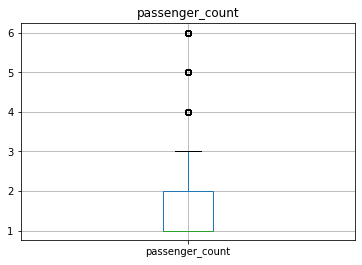

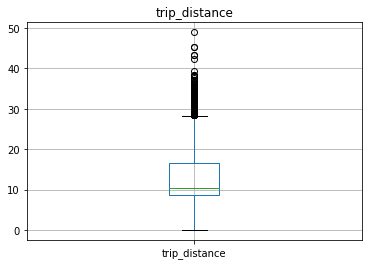

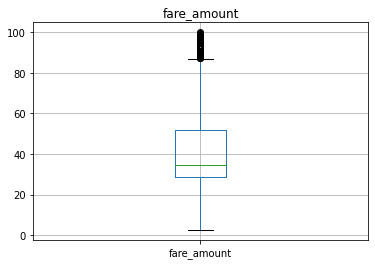

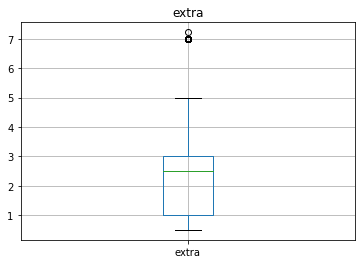

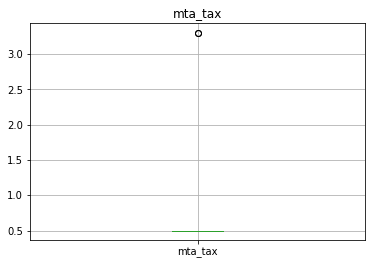

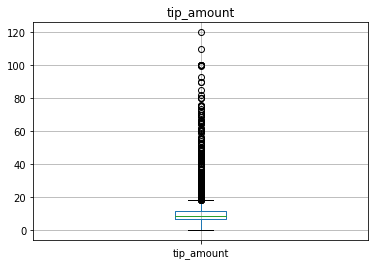

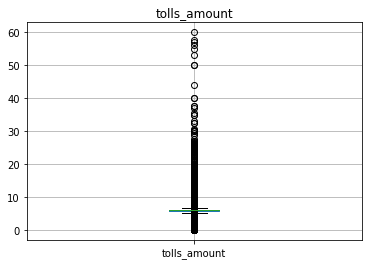

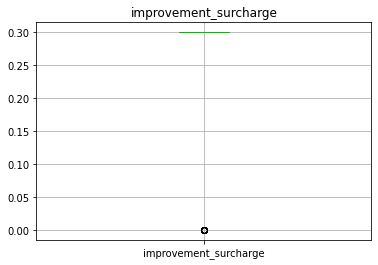

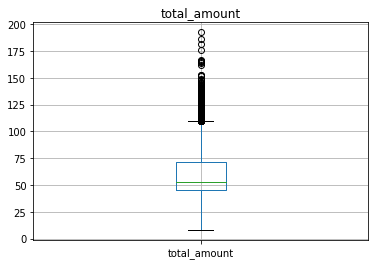

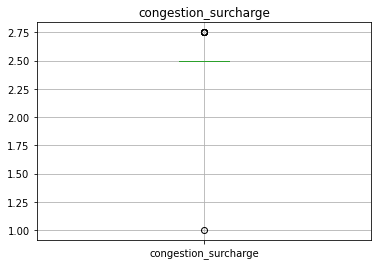

In [112]:
for i in numerical_data:
    df_taxi.boxplot(column= i)
    plt.title(i)
    plt.show()

<AxesSubplot:>

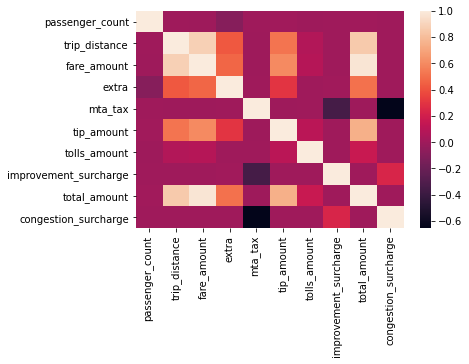

In [38]:
sns.heatmap(df_taxi[numerical_data].corr())

Inference:
As expected, there is a correlation between fare amount and total amount. There is als a correlation between total_amount and tip_amount

## Cleaning Categorical Data

In [117]:
categorical_data= ['VendorID', 'RatecodeID', 'payment_type']

In [118]:
#Check if the values align with the values given with the 
# data details
for i in categorical_data:
    print(i+ ':',df_tot[i].value_counts().index)

VendorID: Int64Index([1, 2, 4], dtype='int64')
RatecodeID: Int64Index([1, 2, 4], dtype='int64')
payment_type: Int64Index([1, 2, 3, 4], dtype='int64')


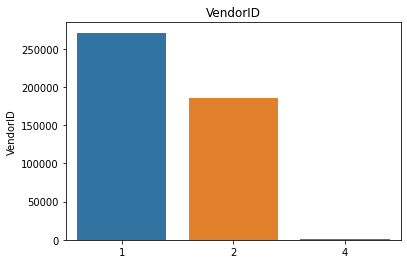

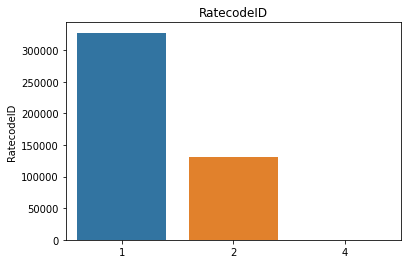

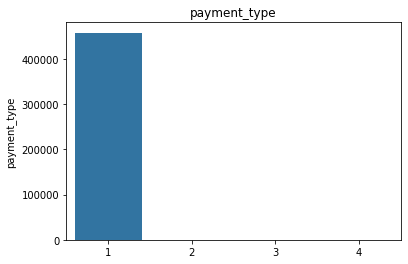

In [119]:
for i in categorical_data:
    sns.barplot(df_tot[i].value_counts().index, df_tot[i].value_counts())
    plt.title(i)
    plt.show()

In [120]:
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458159 entries, 2 to 22830913
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               458159 non-null  int16         
 1   tpep_pickup_datetime   458159 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  458159 non-null  datetime64[ns]
 3   passenger_count        458159 non-null  int16         
 4   trip_distance          458159 non-null  float32       
 5   RatecodeID             458159 non-null  int16         
 6   PULocationID           458159 non-null  int16         
 7   DOLocationID           458159 non-null  int16         
 8   payment_type           458159 non-null  int16         
 9   fare_amount            458159 non-null  float32       
 10  extra                  458159 non-null  float32       
 11  mta_tax                458159 non-null  float32       
 12  tip_amount             458159 non-null  fl

### Checking and removing invalid DateTime Data 

Check for and remove invalid trips where there was a pickup after the dropoff. There cannot be a trip where there is 0 seconds trip since there is a minimum of 2.50 fee

In [538]:
df_tot_uber.loc[df_tot_uber['pickup_datetime']>= df_tot_uber['dropoff_datetime']].count()

dispatching_base_num    0
pickup_datetime         0
dropoff_datetime        0
PULocationID            0
DOLocationID            0
PUdatetime              0
DOdatetime              0
dtype: int64

In [138]:
df_tot_uber= df_tot_uber.loc[df_tot_uber['pickup_datetime']< df_tot_uber['dropoff_datetime']]

## Check Location Zone Data for duplicates

In [396]:
dfzone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       265 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.4+ KB


In [397]:
dfzone.describe()

,LocationID
count,265.000000
mean,133.000000
std,76.643112
min,1.000000
25%,67.000000
50%,133.000000
75%,199.000000
max,265.000000


In [398]:
from sridentify import Sridentify
ident = Sridentify()
# from file
ident.from_file("../data/large/taxi_zones.prj")
ident.get_epsg()

2263

In [399]:
# the following code was borrowed from https://chih-ling-hsu.github.io/2018/05/14/NYC

def convert_to_longlat_type(x,y):
    inProj = Proj(init='epsg:2263')
    outProj = Proj(init='epsg:4326')
    return transform(inProj,outProj,x,y)

def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        long_x, lat_y= convert_to_longlat_type(x,y)
        content.append((loc_id, long_x, lat_y))
        
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [400]:
# the following code was borrowed from https://chih-ling-hsu.github.io/2018/05/14/NYC
print(dfzoneshp.fields)
dfzoneshp.fields[1:]

[('DeletionFlag', 'C', 1, 0), ['OBJECTID', 'N', 9, 0], ['Shape_Leng', 'F', 19, 11], ['Shape_Area', 'F', 19, 11], ['zone', 'C', 254, 0], ['LocationID', 'N', 4, 0], ['borough', 'C', 254, 0]]


[['OBJECTID', 'N', 9, 0],
 ['Shape_Leng', 'F', 19, 11],
 ['Shape_Area', 'F', 19, 11],
 ['zone', 'C', 254, 0],
 ['LocationID', 'N', 4, 0],
 ['borough', 'C', 254, 0]]

In [401]:
 #remove deletion flag and save feature names
fields_name = [field[0] for field in dfzoneshp.fields[1:]]
#make a dict with the features and the column number
dfzoneshp_dic = dict(zip(fields_name, list(range(len(fields_name)))))

#Save records into dictionary
records = sf.records()
dfzoneshp_records = [dict(zip(fields_name, rec)) for rec in records]
#join the data into a df along with the longitude and latitude
dfzoneloc = pd.DataFrame(dfzoneshp_records).join(get_lat_lon(dfzoneshp).set_index("LocationID"), on="LocationID")
dfzoneloc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171526,40.689488
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822490,40.610791
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844947,40.865745
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977726,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187537,40.550665


### Join Location data and Information data

In [402]:
print(dfzoneloc.shape)
dfzoneloc[dfzoneloc['LocationID'].duplicated(keep=False) == True]

(271, 8)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
55,56,0.056848,0.000181,Corona,56,Queens,-73.857709,40.741565
55,56,0.056848,0.000181,Corona,56,Queens,-73.853347,40.751980
56,57,0.019271,0.000018,Corona,56,Queens,-73.857709,40.741565
56,57,0.019271,0.000018,Corona,56,Queens,-73.853347,40.751980
102,103,0.014306,0.000006,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.045142,40.689819
102,103,0.014306,0.000006,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.040693,40.698672
102,103,0.014306,0.000006,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.019189,40.688135
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.045142,40.689819
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.040693,40.698672
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.019189,40.688135


In [403]:
dfzoneloc= dfzoneloc.drop_duplicates(subset=['LocationID'])

In [404]:
print(dfzoneloc.shape)
dfzoneloc[dfzoneloc['LocationID'].duplicated(keep=False) == True]


(260, 8)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude


Since there are no more duplicates and the location ID matches the location ID column in dfzone, dfzone.loc 

In [405]:
dfzone= dfzone.join(dfzoneloc[['longitude', 'latitude']], on= 'LocationID', how= "left")

In [507]:
del dfzoneloc

In [406]:
dfzone.head()

,LocationID,Borough,Zone,service_zone,longitude,latitude
0,1,EWR,Newark Airport,EWR,-73.822490,40.610791
1,2,Queens,Jamaica Bay,Boro Zone,-73.844947,40.865745
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,-73.977726,40.724137
3,4,Manhattan,Alphabet City,Yellow Zone,-74.187537,40.550665
4,5,Staten Island,Arden Heights,Boro Zone,-74.072564,40.599047


### Check for Duplicates

In [407]:
print("There is duplicates. This statement is:", dfzone.duplicated(subset=['Borough', 'Zone', 'service_zone']).any())
dfzone[dfzone[['Borough', 'Zone', 'service_zone']].duplicated(keep=False) == True]

There is duplicates. This statement is: True


,LocationID,Borough,Zone,service_zone,longitude,latitude
55,56,Queens,Corona,Boro Zone,NaN,NaN
56,57,Queens,Corona,Boro Zone,-73.818980,40.841493
102,103,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone,NaN,NaN
103,104,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone,NaN,NaN
104,105,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone,-73.990188,40.673258


In [408]:
#Checking Location ID 56 and 57
print("The number of trips with PUlocation ID of 56 is", len(df_tot.loc[df_tot['PULocationID']== 56]))
print("The number of trips with PUlocation ID of 57 is", len(df_tot.loc[df_tot['PULocationID']== 57]))
#Checking location ID 103,104,105
print("The number of trips with PUlocation ID of 103 is", len(df_tot.loc[df_tot['PULocationID']== 103]))
print("The number of trips with PUlocation ID of 104 is", len(df_tot.loc[df_tot['PULocationID']== 104]))
print("The number of trips with PUlocation ID of 105 is", len(df_tot.loc[df_tot['PULocationID']== 105]))

The number of trips with PUlocation ID of 56 is 180
The number of trips with PUlocation ID of 57 is 0
The number of trips with PUlocation ID of 103 is 0
The number of trips with PUlocation ID of 104 is 0
The number of trips with PUlocation ID of 105 is 0


Since there is only 3 PULocationID from area 57. It is safe to assume that there may have been a mistake and the same location was matched to a locationID twice. Hence, all trips from locationid 57 will be marked as 56.
As for the the last 3 locationsIDs,it is safe to delete the values since there is 0 matches to our data.

In [409]:
df_tot.loc[df_tot['PULocationID']== 57] = 56
df_tot.loc[df_tot['DOLocationID']== 57] = 56
dfzone.drop([102, 103, 104])

,LocationID,Borough,Zone,service_zone,longitude,latitude
0,1,EWR,Newark Airport,EWR,-73.822490,40.610791
1,2,Queens,Jamaica Bay,Boro Zone,-73.844947,40.865745
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,-73.977726,40.724137
3,4,Manhattan,Alphabet City,Yellow Zone,-74.187537,40.550665
4,5,Staten Island,Arden Heights,Boro Zone,-74.072564,40.599047
...,...,...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone,-73.945142,40.776681
261,262,Manhattan,Yorkville East,Yellow Zone,-73.951009,40.778766
262,263,Manhattan,Yorkville West,Yellow Zone,NaN,NaN
263,264,Unknown,NV,NaN,NaN,NaN


### Delete Invalid Zones

Remove the last two invalid entries and any other similar entries

In [410]:
dfzone.loc[dfzone["Borough"]=='Unknown']

,LocationID,Borough,Zone,service_zone,longitude,latitude
263,264,Unknown,NV,NaN,NaN,NaN
264,265,Unknown,NaN,NaN,NaN,NaN


In [411]:
dfzone.drop([263, 264])

,LocationID,Borough,Zone,service_zone,longitude,latitude
0,1,EWR,Newark Airport,EWR,-73.822490,40.610791
1,2,Queens,Jamaica Bay,Boro Zone,-73.844947,40.865745
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,-73.977726,40.724137
3,4,Manhattan,Alphabet City,Yellow Zone,-74.187537,40.550665
4,5,Staten Island,Arden Heights,Boro Zone,-74.072564,40.599047
...,...,...,...,...,...,...
258,259,Bronx,Woodlawn/Wakefield,Boro Zone,-73.906841,40.746605
259,260,Queens,Woodside,Boro Zone,-74.012644,40.709120
260,261,Manhattan,World Trade Center,Yellow Zone,-73.945142,40.776681
261,262,Manhattan,Yorkville East,Yellow Zone,-73.951009,40.778766


In [412]:
dfzone= dfzone.drop_duplicates(subset=['Borough', 'Zone', 'service_zone'])

Before:  (265, 6)
After:  (262, 6)


### Delete where there is no location details

In [413]:
dfzone= dfzone.loc[dfzone["longitude"].notna()]
dfzone= dfzone.loc[dfzone["latitude"].notna()]

Delete the entries from uber and the taxi dataset that don't have a location

In [422]:
locationID_list= list(dfzone["LocationID"])
maximum_locID= max(df_tot.max()['PULocationID'], df_tot_uber.max()['PULocationID'])
maximum_locID= max(maximum_locID, df_tot.max()['DOLocationID'])
maximum_locID= max(maximum_locID, df_tot_uber.max()['DOLocationID'])

for i in range(1,int(maximum_locID)):
    if i not in locationID_list:
        if df_tot.loc[df_tot['PULocationID']==i].shape[0]>0:
            df_tot= df_tot.loc[df_tot['PULocationID']!=i]
        if df_tot.loc[df_tot['DOLocationID']==i].shape[0]>0:
            df_tot= df_tot.loc[df_tot['DOLocationID']!=i]
        if df_tot_uber.loc[df_tot_uber['PULocationID']==i].shape[0]>0:
            df_tot_uber= df_tot_uber.loc[df_tot_uber['PULocationID']!=i]
        if df_tot_uber.loc[df_tot_uber['DOLocationID']==i].shape[0]>0:
            df_tot_uber= df_tot_uber.loc[df_tot_uber['DOLocationID']!=i]
    
    

## Saving Weather Data

In [519]:
dfweather = pd.read_csv("../data/large/weather_data_3-5_2019.csv")
dfweather.reset_index().to_feather('../data/large/weather_data_3-5_2019.feather')
dfweather = pd.read_feather('../data/large/weather_data_3-5_2019.feather')

In [520]:
dfweather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867 entries, 0 to 2866
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    2867 non-null   int64  
 1   station  2867 non-null   object 
 2   valid    2867 non-null   object 
 3   lon      2867 non-null   float64
 4   lat      2867 non-null   float64
 5   tmpf     2774 non-null   float64
 6   tmpc     2774 non-null   float64
 7   dwpf     2774 non-null   float64
 8   dwpc     2774 non-null   float64
 9   relh     2774 non-null   float64
 10  feel     2212 non-null   float64
 11  drct     1513 non-null   float64
 12  sknt     2281 non-null   float64
 13  sped     2281 non-null   float64
 14  alti     2860 non-null   float64
 15  mslp     2096 non-null   float64
 16  p01m     2867 non-null   object 
dtypes: float64(13), int64(1), object(3)
memory usage: 380.9+ KB


In [521]:
dfweather= dfweather.rename(columns={"valid":"datetime", "lon": "longitude", "lat": "latitude", "tmpf": "tempF", "relh": "relhumidity", "p01m" : "precipitation" }, errors="raise")

In [522]:
dfweather= dfweather.drop(columns=['index','station','tmpc', 'dwpf','dwpc', 'feel', 'drct', 'sknt', 'sped', 'alti', 'mslp'])

In [523]:
dfweather['datetime']= dfweather['datetime'].apply(lambda ogdate: datetime.strptime(str(ogdate), '%Y-%m-%d %H:%M'))

In [524]:
#check if there is missing entries
print(dfweather.isnull().sum())

datetime          0
longitude         0
latitude          0
tempF            93
relhumidity      93
precipitation     0
dtype: int64


In [525]:
dfweather= dfweather.loc[dfweather['relhumidity'].notna()]
dfweater= dfweather.loc[dfweather['precipitation'].notna()]

,datetime,longitude,latitude,tempF,relhumidity,precipitation
0,2019-03-01 00:51:00,-73.9693,40.779,30.0,44.37,0.00
1,2019-03-01 01:51:00,-73.9693,40.779,30.0,50.88,0.00
2,2019-03-01 02:51:00,-73.9693,40.779,30.0,53.38,0.00
3,2019-03-01 03:51:00,-73.9693,40.779,30.0,55.52,0.00
4,2019-03-01 04:48:00,-73.9693,40.779,28.4,68.61,T
...,...,...,...,...,...,...
2862,2019-05-30 22:40:00,-73.9693,40.779,63.0,96.88,T
2863,2019-05-30 22:51:00,-73.9693,40.779,63.0,96.88,T
2864,2019-05-30 23:05:00,-73.9693,40.779,63.0,96.88,0.00
2865,2019-05-30 23:44:00,-73.9693,40.779,64.9,93.56,0.00


In [526]:
dfweather.describe().round()

,longitude,latitude,tempF,relhumidity
count,2867.0,2867.0,2774.0,2774.0
mean,-74.0,41.0,52.0,66.0
std,0.0,0.0,12.0,23.0
min,-74.0,41.0,18.0,13.0
25%,-74.0,41.0,44.0,47.0
50%,-74.0,41.0,52.0,69.0
75%,-74.0,41.0,60.0,90.0
max,-74.0,41.0,86.0,100.0


The longitude and latitude seems to be unnecessary information since all of are the same (-74longitude and 41 latitude). Hence it can be deleted

In [527]:
dfweather= dfweather.drop(columns =['longitude', 'latitude'])

,datetime,tempF,relhumidity,precipitation
0,2019-03-01 00:51:00,30.0,44.37,0.00
1,2019-03-01 01:51:00,30.0,50.88,0.00
2,2019-03-01 02:51:00,30.0,53.38,0.00
3,2019-03-01 03:51:00,30.0,55.52,0.00
4,2019-03-01 04:48:00,28.4,68.61,T
...,...,...,...,...
2862,2019-05-30 22:40:00,63.0,96.88,T
2863,2019-05-30 22:51:00,63.0,96.88,T
2864,2019-05-30 23:05:00,63.0,96.88,0.00
2865,2019-05-30 23:44:00,64.9,93.56,0.00


In [528]:
# https://www.thoughtco.com/what-is-trace-of-precipitation-3444238
dfweather.loc[dfweather['precipitation']=="T", 'precipitation']= 0.005 #changed to 0.005 because meteoroligst counts min 0.01
dfweather["precipitation"] = dfweather["precipitation"].apply(pd.to_numeric)
dfweather.loc[dfweather["precipitation"]>0.00]

,datetime,longitude,latitude,tempF,relhumidity,precipitation
4,2019-03-01 04:48:00,-73.9693,40.779,28.4,68.61,0.005
5,2019-03-01 04:51:00,-73.9693,40.779,28.9,68.67,0.005
6,2019-03-01 04:56:00,-73.9693,40.779,28.0,77.57,0.005
7,2019-03-01 05:05:00,-73.9693,40.779,27.0,84.66,0.510
8,2019-03-01 05:13:00,-73.9693,40.779,27.0,84.66,1.020
...,...,...,...,...,...,...
2859,2019-05-30 22:16:00,-73.9693,40.779,63.0,96.88,0.005
2860,2019-05-30 22:24:00,-73.9693,40.779,63.0,96.88,0.005
2861,2019-05-30 22:31:00,-73.9693,40.779,63.0,96.88,0.005
2862,2019-05-30 22:40:00,-73.9693,40.779,63.0,96.88,0.005


### Save Weather Dataset to Folder

In [ ]:
dfweather.to_csv('../preprocessed_data/', index=False)

## Linking Weather, Uber and Taxi Dataset


Columns: Pickup_datetime, dropoff_datetime, total amount average difference per min, tips amount average difference per min, total trips counts difference per minute, weather

In [539]:
df_tot_copy= df_tot.copy()
df_tot_uber_copy= df_tot_uber.copy()

In [544]:
#group by hour
df_tot_group= df_tot_copy.sort_values(by= 'PUdatetime')
df_tot_group

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,hr_of_day24,PUdatetime,DOdatetime
1205016,2,2009-01-01 00:14:39,2009-01-01 22:05:46,1,9.00,1,138,234,1,27.5,0.5,0.5,7.41,5.76,0.3,44.470001,2.5,0,2009-01-01 00:00:00,2009-01-01 22:00:00
7077,2,2019-02-28 17:09:40,2019-02-28 17:32:50,1,10.17,1,138,48,1,30.0,0.5,0.5,7.00,5.76,0.3,46.560001,2.5,17,2019-02-28 17:00:00,2019-02-28 17:00:00
5415,2,2019-02-28 23:58:01,2019-03-01 00:24:04,6,10.42,1,138,163,1,31.5,0.5,0.5,8.21,5.76,0.3,49.270000,2.5,23,2019-02-28 23:00:00,2019-03-01 00:00:00
2627,2,2019-02-28 23:59:47,2019-03-01 00:17:25,6,10.01,1,138,229,1,28.5,0.5,0.5,7.61,5.76,0.3,45.669998,2.5,23,2019-02-28 23:00:00,2019-03-01 00:00:00
5459,2,2019-03-01 00:12:45,2019-03-01 00:51:05,1,11.22,1,230,190,1,36.0,0.5,0.5,8.00,5.76,0.3,53.560001,2.5,0,2019-03-01 00:00:00,2019-03-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22821615,1,2019-05-31 23:12:45,2019-05-31 23:32:57,1,8.40,1,148,257,1,25.5,3.0,0.5,3.00,6.12,0.3,38.419998,2.5,23,2019-05-31 23:00:00,2019-05-31 23:00:00
22821907,2,2019-05-31 23:23:05,2019-06-01 00:03:45,6,8.90,1,138,107,1,36.5,0.5,0.5,11.60,6.12,0.3,58.020000,2.5,23,2019-05-31 23:00:00,2019-06-01 00:00:00
22739169,2,2019-06-02 13:22:53,2019-06-02 14:17:22,1,17.98,2,234,132,1,52.0,4.5,0.5,13.18,6.12,0.3,79.099998,2.5,13,2019-06-02 13:00:00,2019-06-02 14:00:00
21268975,2,2019-07-05 16:40:47,2019-07-05 17:28:06,2,10.75,1,163,138,1,37.5,1.0,0.5,9.58,6.12,0.3,57.500000,2.5,16,2019-07-05 16:00:00,2019-07-05 17:00:00


In [545]:
df_tot_grou
pd.merge(df_tot_group, df_tot_uber_group, on= 'PUdatetime')

KeyError: 'PUdatetime'

In [ ]:
df_tot_group= df_tot_copy.sort_values(by= 'PULocationID')
df_tot_group['taxi_demand']= df_tot_group.groupby('PULocationID')['PULocationID'].transform('count')


In [ ]:
#MAKE DF 
#df= [df_tot_group columns,
#     numberr of entry difference compared to taxi dataset]
df_tot_group['trips difference per PULocationID']= df_tot_uber_group['trips per PULocationID']- df_tot_group['trips per PULocationID']

In [ ]:
#df_tot_uber_group.loc[df_tot_uber_group["PULocationID"]==1]["trips per PULocationID"].iloc[0]

In [ ]:
#df_tot_group['uber trips per PULocationID']= df_tot_group["PULocationID"].apply(lambda locID: df_tot_uber_group.loc[df_tot_uber_group["PULocationID"]==locID]["trips per PULocationID"].iloc[0])

In [ ]:
taxi_locdata = {"PULocationID": df_tot_group['PULocationID'], 'trips per PULocationID': df_tot_group['trips per PULocationID']}
taxi_locdf= pd.DataFrame(taxi_locdata)
uber_locdata = {"PULocationID": df_tot_uber_group['PULocationID'], 'trips per PULocationID': df_tot_uber_group['trips per PULocationID']}
uber_locdf= pd.DataFrame(uber_locdata)
pd.merge(taxi_locdf, uber_locdf, on='PULocationID', how='left')


In [ ]:
df_tot_group['uber trips per PULocationID']

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

X = df_tot.iloc[:, df_tot.columns != 'tpep_pickup_datetime']  #independent columns
y = df_tot.iloc[:,2]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func= chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
print(featureScores.nlargest(10,'Score'))  #print 10 best features

### Remove Invalid Locations
After removing Unknown Boroughs from dfzone, we also need to remove it from dftot

In [77]:
df_taxi= df_taxi.loc[df_tot['PULocationID']<= 263]
df_taxi= df_df_taxi.loc[df_tot['DOLocationID']<= 263]